In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import glob
import sys
import cv2
#import imageio
import joblib
import math
import warnings
import os
import torch
#import imagehash
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D,AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

In [ ]:
train_df = pd.read_csv('/kaggle/input/590-yolo/yolotrain.csv')

In [ ]:
train_df['label'].head(5)

In [ ]:
train_df.drop(train_df[train_df.label == 'unknown'].index, inplace=True)

In [ ]:
len(train_df.loc[train_df['label'] == 'dog'])

In [ ]:
################## Regression ###################

In [ ]:
# cat = 1, dog = 0
train_df['label'] = (train_df['label'] == 'cat').astype(int)

In [ ]:
train_df.drop('Unnamed: 0', axis=1, inplace=True)
train_df['filename'] = train_df['Id']+'.jpg'
#train_df.drop('img_path', axis=1, inplace=True)
train_df.drop('Id', axis=1, inplace=True)
train_df.drop('file_path', axis=1, inplace=True)
train_df.drop('coords', axis=1, inplace=True)
train_df.drop('x_min', axis=1, inplace=True)
train_df.drop('x_max', axis=1, inplace=True)
train_df.drop('y_min', axis=1, inplace=True)
train_df.drop('y_max', axis=1, inplace=True)

In [ ]:
cat_df = train_df.loc[train_df['label'] == 1]
dog_df = train_df.loc[train_df['label'] == 0]
cat_df.drop('label', axis=1, inplace=True)
dog_df.drop('label', axis=1, inplace=True)

In [ ]:
#######################################################################
################################ CAT ##################################

In [ ]:
gen_kwargs = dict(
    dataframe=cat_df,
    directory=Path('/kaggle/input/petfinder-pawpularity-score/train'), 
    x_col='filename',
    y_col='Pawpularity',
    batch_size=32,
    seed=619,
    shuffle=True,
    class_mode='raw',
    target_size=(224, 224)
)
datagen = ImageDataGenerator(rescale=1/255,validation_split=0.2)
train_generator_cat =  datagen.flow_from_dataframe(**gen_kwargs, subset="training")
valid_generator_cat =  datagen.flow_from_dataframe(**gen_kwargs, subset="validation")

In [4]:
inputs = keras.Input(shape=(224, 224, 3))

X = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
X = AveragePooling2D(pool_size=(2, 2))(X)

X = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(X)
X = AveragePooling2D(pool_size=(2, 2))(X)

X = Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(X)
X = AveragePooling2D(pool_size=(2, 2))(X)

X = Flatten()(X)

X = Dense(512, activation='relu')(X)
X = Dropout(0.3)(X)

X = Dense(128, activation='relu')(X)

X = Dense(64, activation='relu')(X)

X = Dense(16, activation='relu')(X)

X = Dense(4, activation='relu')(X)

outputs = Dense(1)(X)

model = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 64)      1792      
                                                                 
 average_pooling2d (AverageP  (None, 56, 56, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 average_pooling2d_1 (Averag  (None, 14, 14, 128)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168

In [5]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[RootMeanSquaredError()]
)

In [29]:
history2 = model.fit(
    train_generator_cat,
    validation_data=valid_generator_cat,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)]
)

Epoch 1/10
133/133 [==============================] - 69s 515ms/step - loss: 580.7891 - root_mean_squared_error: 23.7083 - val_loss: 311.9473 - val_root_mean_squared_error: 17.6620
Epoch 2/10
133/133 [==============================] - 69s 518ms/step - loss: 336.7910 - root_mean_squared_error: 18.3346 - val_loss: 310.5268 - val_root_mean_squared_error: 17.6218
Epoch 3/10
133/133 [==============================] - 69s 516ms/step - loss: 339.9320 - root_mean_squared_error: 18.4319 - val_loss: 331.6282 - val_root_mean_squared_error: 18.2107
Epoch 4/10
133/133 [==============================] - 68s 509ms/step - loss: 317.1765 - root_mean_squared_error: 17.8048 - val_loss: 312.6212 - val_root_mean_squared_error: 17.6811
Epoch 5/10
133/133 [==============================] - 68s 510ms/step - loss: 303.9951 - root_mean_squared_error: 17.4237 - val_loss: 311.7322 - val_root_mean_squared_error: 17.6559
Epoch 6/10
133/133 [==============================] - 68s 512ms/step - loss: 310.3347 - root_me

In [76]:
history2.history

{'loss': [408.3161315917969,
  321.777587890625,
  330.0317077636719,
  327.3998718261719,
  320.01995849609375,
  312.32177734375,
  310.8185729980469,
  308.8414306640625,
  325.19305419921875,
  318.40350341796875],
 'root_mean_squared_error': [20.206832885742188,
  17.938159942626953,
  18.16677474975586,
  18.094194412231445,
  17.889101028442383,
  17.67262840270996,
  17.630046844482422,
  17.573884963989258,
  18.033109664916992,
  17.84386444091797],
 'val_loss': [311.94732666015625,
  310.5268249511719,
  331.6282043457031,
  312.62115478515625,
  311.7322082519531,
  307.520263671875,
  305.60052490234375,
  306.0946044921875,
  306.0256042480469,
  305.0485534667969],
 'val_root_mean_squared_error': [17.662031173706055,
  17.62177085876465,
  18.210660934448242,
  17.681095123291016,
  17.65593910217285,
  17.5362548828125,
  17.481433868408203,
  17.495559692382812,
  17.493587493896484,
  17.465639114379883]}

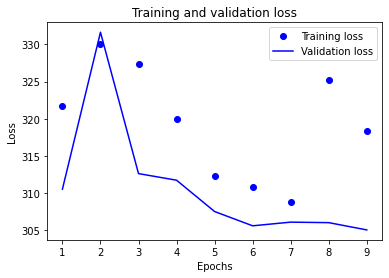

In [92]:
# Plot
history_dict = history2.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
plt.plot(range(1, len(loss_values)), loss_values[1:], 'bo', label='Training loss')
plt.plot(range(1, len(val_loss_values)), val_loss_values[1:], 'b', label='Validation loss')
plt.legend(loc='upper center',frameon=False,ncol=2,bbox_to_anchor=(.5, 1.1))
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


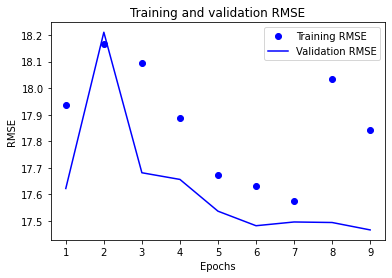

In [93]:
RMSE = history_dict['root_mean_squared_error']
val_RMSE = history_dict['val_root_mean_squared_error']
plt.plot(range(1, len(RMSE)), RMSE[1:], 'bo', label='Training RMSE')
plt.plot(range(1, len(RMSE)), val_RMSE[1:], 'b', label='Validation RMSE')
plt.title('Training and validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [67]:
df_test = pd.read_csv('/kaggle/input/590-yolo/yolov5.csv', index_col='Id')
df_test.drop('Unnamed: 0', axis=1, inplace=True)
df_test.head(5)

,true_label,file_path,pred_label
Id,,,
IMG_0969.JPG,0,/kaggle/input/own-tests/IMG_0969.JPG,dog
IMG_0982.JPG,1,/kaggle/input/own-tests/IMG_0982.JPG,cat
IMG_0983.JPG,1,/kaggle/input/own-tests/IMG_0983.JPG,cat
IMG_0968.JPG,0,/kaggle/input/own-tests/IMG_0968.JPG,dog
IMG_0981.JPG,1,/kaggle/input/own-tests/IMG_0981.JPG,cat


In [68]:
df_test = df_test.loc[df_test['true_label'] == 1]

In [69]:
df_test['filename'] = df_test.index
df_test.drop('pred_label', axis=1, inplace=True)
df_test.head(5)

,true_label,file_path,filename
Id,,,
IMG_0982.JPG,1,/kaggle/input/own-tests/IMG_0982.JPG,IMG_0982.JPG
IMG_0983.JPG,1,/kaggle/input/own-tests/IMG_0983.JPG,IMG_0983.JPG
IMG_0981.JPG,1,/kaggle/input/own-tests/IMG_0981.JPG,IMG_0981.JPG
IMG_0980.JPG,1,/kaggle/input/own-tests/IMG_0980.JPG,IMG_0980.JPG
IMG_0984.JPG,1,/kaggle/input/own-tests/IMG_0984.JPG,IMG_0984.JPG


In [70]:
df_test.drop('file_path', axis=1, inplace=True)

In [71]:
test_generator = datagen.flow_from_dataframe(dataframe=df_test,
                                             directory=Path('/kaggle/input/own-tests'), 
                                             x_col='filename',
                                             y_col=None,
                                             batch_size=32,
                                             seed=42,
                                             shuffle=False,
                                             class_mode=None,
                                             target_size=(224, 224)
                                            )

Found 15 validated image filenames.


In [72]:
yhat_test = model.predict(test_generator, verbose=1)

1/1 [==============================] - 1s 1s/step


In [73]:
yhat_test 

array([[34.23224 ],
       [34.030384],
       [33.422684],
       [33.744762],
       [33.62027 ],
       [34.939392],
       [35.084366],
       [34.77715 ],
       [32.284573],
       [38.78756 ],
       [35.304672],
       [36.663284],
       [36.99951 ],
       [36.36168 ],
       [34.788887]], dtype=float32)

In [74]:
frames = [
    pd.Series(df_test.index.values, name='Id'),
    pd.Series(yhat_test.ravel(), name='Pawpularity')
]
submission = pd.concat(frames, axis=1)
submission.head()

,Id,Pawpularity
0,IMG_0982.JPG,34.232239
1,IMG_0983.JPG,34.030384
2,IMG_0981.JPG,33.422684
3,IMG_0980.JPG,33.744762
4,IMG_0984.JPG,33.620270


In [91]:
submission.sort_values(by=['Pawpularity'], ascending=False)

,Id,Pawpularity
9,WechatIMG825.JPG,38.787560
12,IMG_0972.JPG,36.999512
11,WechatIMG826.JPG,36.663284
13,IMG_0973.JPG,36.361679
10,IMG_0975.JPG,35.304672
6,IMG_0979.JPG,35.084366
5,IMG_0985.JPG,34.939392
14,WechatIMG823.JPG,34.788887
7,IMG_0974.JPG,34.777149
0,IMG_0982.JPG,34.232239
